In [4]:
% matplotlib inline
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [6]:
DATA_STORE = 'data/assets.h5'
START = 2000
END = 2018

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']).loc[idx[str(START):str(END), :], 'adj_close'].unstack('ticker')
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [8]:
# stocks.iloc[:10]
prices.tail(5)

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-21,69.40,47.95,54.09,60.80,47.37,26.71,39.05,115.24,171.270,32.46,...,4.28,4.53,NaN,NaN,NaN,3.94,15.66,NaN,84.10,23.95
2018-03-22,67.47,44.92,52.31,60.18,45.94,25.96,38.55,111.71,168.845,32.52,...,4.19,4.52,NaN,NaN,NaN,3.81,15.27,NaN,82.06,23.35
2018-03-23,66.06,44.71,51.01,58.35,45.30,25.36,37.20,110.84,164.940,31.78,...,4.05,4.40,NaN,NaN,NaN,3.80,15.12,NaN,80.60,23.55
2018-03-26,68.20,45.77,51.86,58.60,46.23,24.53,37.95,114.77,172.770,32.22,...,4.27,4.42,NaN,NaN,NaN,3.85,15.10,NaN,83.73,24.65
2018-03-27,67.00,44.90,50.90,65.25,45.42,24.60,38.00,115.01,168.340,32.75,...,4.05,4.39,NaN,NaN,NaN,3.70,14.88,NaN,81.86,23.60


In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'
shared = prices.columns.intersection(stocks.index)
stocks = stocks.loc[shared, :]
stocks.info()
stocks.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


,marketcap,ipoyear,sector
ticker,,,
ZIXI,2.944800e+08,NaN,Technology
ZNGA,3.550000e+09,2011.0,Technology
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZUMZ,6.316500e+08,2005.0,Consumer Services


In [10]:
prices = prices.loc[:, shared]
prices.info()
prices.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-21,69.40,47.95,54.09,60.80,47.37,26.71,39.05,115.24,171.270,32.46,...,48.89,22.12,42.10,55.10,4.28,4.53,3.94,15.66,84.10,23.95
2018-03-22,67.47,44.92,52.31,60.18,45.94,25.96,38.55,111.71,168.845,32.52,...,48.12,20.65,41.05,53.07,4.19,4.52,3.81,15.27,82.06,23.35
2018-03-23,66.06,44.71,51.01,58.35,45.30,25.36,37.20,110.84,164.940,31.78,...,46.70,20.00,40.35,51.23,4.05,4.40,3.80,15.12,80.60,23.55
2018-03-26,68.20,45.77,51.86,58.60,46.23,24.53,37.95,114.77,172.770,32.22,...,49.04,20.42,40.35,53.24,4.27,4.42,3.85,15.10,83.73,24.65
2018-03-27,67.00,44.90,50.90,65.25,45.42,24.60,38.00,115.01,168.340,32.75,...,47.52,20.25,38.50,52.02,4.05,4.39,3.70,14.88,81.86,23.60


In [11]:
assert prices.shape[1] == stocks.shape[0]

In [12]:
monthly_prices = prices.resample('M').last()
monthly_prices.info()
monthly_prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,45.157511,NaN,NaN,NaN,4.766882,NaN,1.211345,NaN,3.333330,NaN,...,NaN,4.176075,NaN,46.927728,NaN,30.88,NaN,NaN,NaN,NaN
2000-02-29,70.884807,NaN,NaN,NaN,4.941969,NaN,1.296459,NaN,3.682567,NaN,...,NaN,4.176075,NaN,42.110354,NaN,53.78,NaN,NaN,NaN,NaN
2000-03-31,70.953031,NaN,NaN,NaN,4.834658,NaN,1.334456,NaN,4.363369,NaN,...,NaN,3.712067,NaN,33.039089,NaN,72.81,NaN,NaN,NaN,NaN
2000-04-30,60.466992,NaN,NaN,NaN,4.360229,NaN,1.595875,NaN,3.985860,NaN,...,NaN,4.408079,NaN,32.935916,NaN,36.94,NaN,NaN,NaN,NaN
2000-05-31,50.233382,NaN,NaN,NaN,4.312221,NaN,1.852735,NaN,2.698793,NaN,...,NaN,4.118538,NaN,36.732135,NaN,28.00,NaN,NaN,NaN,NaN


In [13]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
# pandas.clip(threshold value - lower/upper)
# pandas.pipe(function name)
# pandas.pow(x) - x의 거듭제곱
for lag in lags:
    # data threshold 1% ~ 99%
    # using geometric mean
    data[f'return_{lag}m'] = (monthly_prices.pct_change(lag).stack().pipe(
        lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1 - outlier_cutoff))).add(1).pow(
        1 / lag).sub(1))

data = data.swaplevel().dropna()
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,399525.000000,399525.000000,399525.000000,399525.000000,399525.000000,399525.000000
mean,0.012106,0.009001,0.007973,0.006824,0.006340,0.006087
std,0.115089,0.081865,0.067177,0.048929,0.040329,0.035207
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046976,-0.031264,-0.024437,-0.015424,-0.011673,-0.009516
50%,0.009317,0.009623,0.009641,0.009245,0.008854,0.008597
75%,0.066276,0.049457,0.042256,0.032103,0.027308,0.024700
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


In [14]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs > min_obs].index

data = data.loc[idx[keep, :], :]
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m  
ticker date                    
ZUMZ   2017-11-30   -0.010687  
       2017-12-31   -0.003996  
       2018-01-31    0.002864  
       2018-02-28   -0.002905  
       2018-03-31    0.021422

In [15]:
data.memory_usage(deep=True)

Index         1665063
return_1m     2886016
return_2m     2886016
return_3m     2886016
return_6m     2886016
return_9m     2886016
return_12m    2886016
dtype: int64

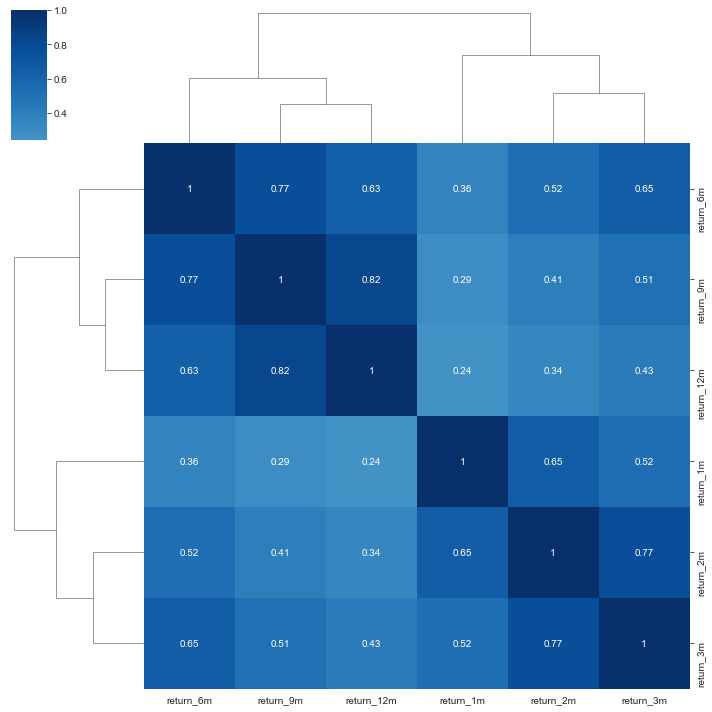

In [16]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')

In [17]:
data.index.get_level_values('ticker').unique()

Index(['A', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ABC', 'ABCB',
       ...
       'YORW', 'YRCW', 'YUM', 'ZBH', 'ZBRA', 'ZEUS', 'ZION', 'ZIOP', 'ZIXI',
       'ZUMZ'],
      dtype='object', name='ticker', length=1838)

In [18]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()
# factor_data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2000-01-31 to 2023-01-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  277 non-null    float64
 1   SMB     277 non-null    float64
 2   HML     277 non-null    float64
 3   RMW     277 non-null    float64
 4   CMA     277 non-null    float64
dtypes: float64(5)
memory usage: 13.0 KB


# Mkt-RF is the return spread between the capitalization-weighted stock market and cash
# SMB is the return spread of small minus large stocks (i.e. the size effect)
# HML is the return spread of cheap minus expensive stocks (i.e. the value effect)
# RMW is the return spread of the most profitable firms minus the least profitable
# CMA is the return spread of firms that invest conservatively minus aggressively (AQR, 2014)

In [19]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [20]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0313  0.0550 -0.0509 -0.0470 -0.0500  -0.003653
       2001-02-28 -0.1005  0.0282  0.1248  0.0911  0.0905  -0.329564
       2001-03-31 -0.0726  0.0233  0.0642  0.0336  0.0391  -0.146389
       2001-04-30  0.0794 -0.0086 -0.0468 -0.0307 -0.0319   0.269444
       2001-05-31  0.0072  0.0359  0.0338  0.0026  0.0188  -0.140220
...                   ...     ...     ...     ...     ...        ...
ZUMZ   2017-11-30  0.0312 -0.0036 -0.0008  0.0319 -0.0008   0.235127
       2017-12-31  0.0106 -0.0107  0.0005  0.0075  0.0167  -0.044725
       2018-01-31  0.0557 -0.0320 -0.0133 -0.0073 -0.0101  -0.003601
       2018-02-28 -0.0365  0.0031 -0.0107  0.0054 -0.0239  -0.050602
       2018-03-31 -0.0235  0.0358 -0.0023 -0.0045  0.0000   0.197970

[360752 rows x 6 columns]

In [21]:
T = 24
betas = (factor_data.groupby(level='ticker', group_keys=False).apply(
    lambda x: RollingOLS(endog=x.return_1m, exog=sm.add_constant(x.drop('return_1m', axis=1)),
                         window=min(T, x.shape[0] - 1)).fit(params_only=True).params.drop('const', axis=1)))

In [22]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.978877,0.626574,0.123491,-0.062149,0.016887,1.486381
std,0.917586,1.254663,1.602559,1.907059,2.155855,3.305914
min,-9.825518,-10.420754,-15.215922,-23.005713,-18.423557,-33.251810
25%,0.463498,-0.119207,-0.706456,-0.973597,-1.071361,0.000000
50%,0.928597,0.541546,0.096100,0.038055,0.040629,1.214857
75%,1.444065,1.303979,0.947862,0.949469,1.135087,3.146895
max,10.858294,10.459489,15.094963,16.977443,16.657684,34.097389


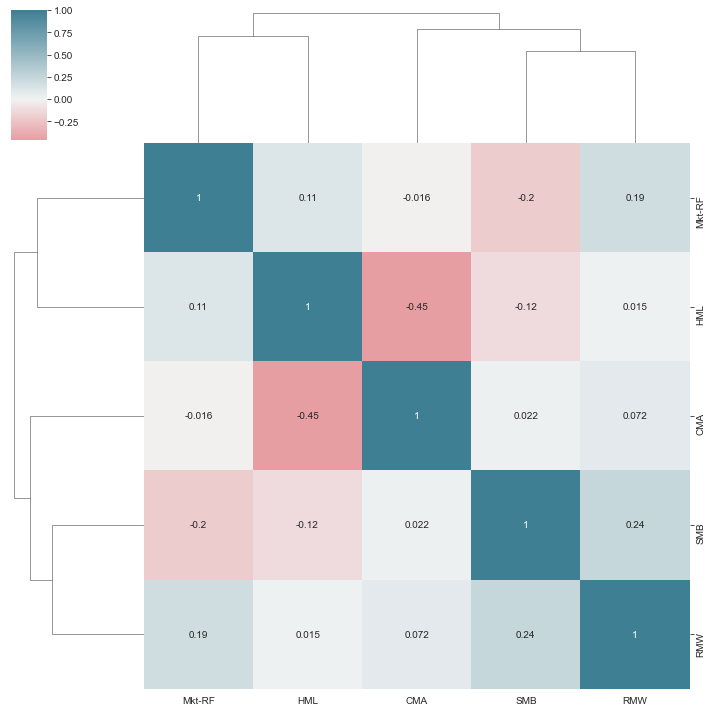

In [23]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [24]:
data = (data.join(betas.groupby(level='ticker').shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


In [25]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988       NaN       NaN       NaN       NaN   
       2001-02-28   -0.084537       NaN       NaN       NaN       NaN   
       2001-03-31   -0.096606       NaN       NaN       NaN       NaN   
       2001-04-30   -0.066102       NaN       NaN       NaN       NaN   
       2001-05-31   -0.063425       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583   
       2018-03-31    0.021422  0.332624  1.030480  1.347272  2.717652   

                        CMA  
ticker date                  
A      2001-01-31       NaN  
       2001-02-28       NaN  
       2001-03-31       NaN  
       2001-04-30       NaN  
       2001-05-31       NaN  
...                     ...  
ZUMZ   2017-11-30  1.303924  
       2017-12-31  1.009348  
       2018-01-31  0.353161  
       2018-02-28  0.641499  
       2018-03-31  0.676412  

[360752 rows x 11 columns]

In [26]:
# impute missing factor betas by mean
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


In [27]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.262247  0.577372 -0.677952 -1.241965   
       2001-02-28   -0.084537  1.262247  0.577372 -0.677952 -1.241965   
       2001-03-31   -0.096606  1.262247  0.577372 -0.677952 -1.241965   
       2001-04-30   -0.066102  1.262247  0.577372 -0.677952 -1.241965   
       2001-05-31   -0.063425  1.262247  0.577372 -0.677952 -1.241965   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583   
       2018-03-31    0.021422  0.332624  1.030480  1.347272  2.717652   

                        CMA  
ticker date                  
A      2001-01-31  0.698731  
       2001-02-28  0.698731  
       2001-03-31  0.698731  
       2001-04-30  0.698731  
       2001-05-31  0.698731  
...                     ...  
ZUMZ   2017-11-30  1.303924  
       2017-12-31  1.009348  
       2018-01-31  0.353161  
       2018-02-28  0.641499  
       2018-03-31  0.676412  

[360752 rows x 11 columns]

In [29]:
for lag in [2, 3, 6, 9, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [30]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.262247  0.577372 -0.677952 -1.241965   
       2001-02-28   -0.084537  1.262247  0.577372 -0.677952 -1.241965   
       2001-03-31   -0.096606  1.262247  0.577372 -0.677952 -1.241965   
       2001-04-30   -0.066102  1.262247  0.577372 -0.677952 -1.241965   
       2001-05-31   -0.063425  1.262247  0.577372 -0.677952 -1.241965   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583   
       2018-03-31    0.021422  0.332624  1.030480  1.347272  2.717652   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.698731    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.698731    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.698731   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.698731   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.698731    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.303924   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  1.009348    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.353161   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.641499    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.676412   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  
ticker date                                    
A      2001-01-31    -0.012335      -0.072092  
       2001-02-28     0.245026       0.031898  
       2001-03-31     0.049783       0.078511  
       2001-04-30    -0.335545       0.039645  
       2001-05-31     0.076795      -0.040108  
...                        ...            ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  
       2017-12-31     0.040729      -0.051853  
       2018-01-31     0.006465      -0.052554  
       2018-02-28     0.047697       0.030295  
       2018-03-31    -0.176548      -0.021157  

[360752 rows x 17 columns]

In [41]:
dates = data.index.get_level_values('date')
data['year'], data['month'] = dates.year, dates.month

In [44]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-02-28   -0.084537  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-03-31   -0.096606  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-04-30   -0.066102  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-05-31   -0.063425  1.262247  0.577372 -0.677952 -1.241965  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964  ...   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731  ...   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790  ...   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583  ...   
       2018-03-31    0.021422  0.332624  1.030480  1.347272  2.717652  ...   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.044725       0.235127      -0.024862   

                   return_1m_t-6  target_1m  target_2m  target_3m  target_6m  \
ticker date                                                                    
A      2001-01-31            NaN  -0.329564  -0.249443  -0.105747  -0.101978   
       2001-02-28            NaN  -0.146389   0.040966  -0.023317  -0.049781   
       2001-03-31            NaN   0.269444   0.044721   0.018842  -0.072607   
       2001-04-30            NaN  -0.140220  -0.087246  -0.098192  -0.089198   
       2001-05-31            NaN  -0.031008  -0.076414  -0.075527  -0.033904   
...                          ...        ...        ...        ...        ...   
ZUMZ   2017-11-30      -0.206128  -0.044725  -0.024380  -0.033200        NaN   
       2017-12-31      -0.133333  -0.003601  -0.027386   0.042579        NaN   
       2018-01-31       0.028340  -0.050602   0.066466        NaN        NaN   
       2018-02-28      -0.019685   0.197970        NaN        NaN        NaN   
 

In [45]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

# For Holding Period Returns

In [ ]:
for t in [1, 2, 3, 6, 12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [47]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-02-28   -0.084537  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-03-31   -0.096606  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-04-30   -0.066102  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-05-31   -0.063425  1.262247  0.577372 -0.677952 -1.241965  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964  ...   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731  ...   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790  ...   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583  ...   
       2018-03-31    0.021422  0.332624  1.030480  1.347272  2.717652  ...   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.044725       0.235127      -0.024862   

                   return_1m_t-6  target_1m  target_2m  target_3m  target_6m  \
ticker date                                                                    
A      2001-01-31            NaN  -0.329564  -0.249443  -0.105747  -0.101978   
       2001-02-28            NaN  -0.146389   0.040966  -0.023317  -0.049781   
       2001-03-31            NaN   0.269444   0.044721   0.018842  -0.072607   
       2001-04-30            NaN  -0.140220  -0.087246  -0.098192  -0.089198   
       2001-05-31            NaN  -0.031008  -0.076414  -0.075527  -0.033904   
...                          ...        ...        ...        ...        ...   
ZUMZ   2017-11-30      -0.206128  -0.044725  -0.024380  -0.033200        NaN   
       2017-12-31      -0.133333  -0.003601  -0.027386   0.042579        NaN   
       2018-01-31       0.028340  -0.050602   0.066466        NaN        NaN   
       2018-02-28      -0.019685   0.197970        NaN        NaN        NaN   
 

In [48]:
cols = ['target_1m', 'target_2m', 'target_3m', 'return_1m', 'return_2m', 'return_3m', 'return_1m_t-1', 'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

In [51]:
data = (data.join(
    pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6))).astype(float).fillna(0).astype(int).to_frame('age')))
data.age = data.age.fillna(-1)

ValueError: columns overlap but no suffix specified: Index(['age'], dtype='object')

In [66]:
size_factor = (monthly_prices.loc[data.index.get_level_values('date').unique(),data.index.get_level_values('ticker').unique()].sort_index(ascending=False).pct_change().fillna(0).add(1).cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1838 entries, A to ZUMZ
dtypes: float64(1838)
memory usage: 2.9 MB


In [80]:
size_factor

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.095970,1.067191,0.900264,0.957895,1.017216,0.994594,0.952583,1.027240,1.186406,1.020000,...,1.027597,1.876616,1.008464,1.171829,0.909198,1.151111,1.038639,0.974074,0.963554,0.879237
2017-12-31,0.999552,1.022200,0.877367,0.965789,0.866794,1.005287,0.993226,0.709964,1.092965,0.918095,...,1.100649,1.689777,0.972938,1.112371,0.766278,1.061235,0.977124,1.022222,0.997722,0.882415
2017-11-30,1.033433,0.991945,0.830471,0.959211,0.878185,1.020851,0.977985,0.698781,1.009642,0.944762,...,1.206169,1.447709,0.995112,1.079462,0.814410,0.983704,0.952518,1.128395,1.002278,0.923729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,0.341528,1.072518,0.099870,0.044896,0.118576,0.007615,0.585097,0.081291,0.143071,0.133726,...,0.159492,16303.937720,0.071803,0.250196,0.147743,0.184687,0.842713,3.950617,2.211845,0.543008
2001-04-30,0.397227,1.072518,0.098187,0.037997,0.118576,0.009730,0.585097,0.063871,0.133873,0.130464,...,0.156495,15593.955347,0.070420,0.250196,0.141936,0.116861,0.826400,3.950617,2.842825,0.543008
2001-03-31,0.312914,1.072518,0.096628,0.038757,0.118576,0.008424,0.585097,0.067936,0.121602,0.133959,...,0.161490,14648.737955,0.060003,0.250196,0.125105,0.106000,0.807791,3.950617,1.601595,0.543008


In [79]:
msize = (size_factor.mul(stocks.loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')
msize

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.960000e+10,1.767000e+10,3.200000e+09,1.810000e+09,9.990000e+09,9.039900e+11,1.830000e+09,1.900000e+09,1.905000e+10,2.160000e+09,...,4.268100e+08,3.429500e+08,2.516000e+10,2.275000e+10,7.920000e+09,2.295400e+08,1.032000e+10,4.357400e+08,2.944800e+08,6.316500e+08
2018-02-28,2.006513e+10,1.883296e+10,3.255658e+09,1.750461e+09,9.923985e+09,9.565088e+11,1.885783e+09,1.816100e+09,2.157836e+10,2.186743e+09,...,3.893948e+08,3.514129e+08,2.441012e+10,2.437949e+10,8.076693e+09,2.553845e+08,1.090524e+10,4.013112e+08,2.716729e+08,5.272672e+08
2018-01-31,2.148101e+10,1.885726e+10,2.880845e+09,1.733789e+09,1.016199e+10,8.991033e+11,1.743226e+09,1.951756e+09,2.260104e+10,2.203200e+09,...,4.385888e+08,6.435854e+08,2.537297e+10,2.665911e+10,7.200850e+09,2.642260e+08,1.071875e+10,4.244430e+08,2.837472e+08,5.553702e+08
2017-12-31,1.959122e+10,1.806228e+10,2.807574e+09,1.748079e+09,8.659274e+09,9.087693e+11,1.817604e+09,1.348932e+09,2.082099e+10,1.983086e+09,...,4.697681e+08,5.795089e+08,2.447911e+10,2.530644e+10,6.068921e+09,2.435958e+08,1.008392e+10,4.454231e+08,2.938092e+08,5.573776e+08
2017-11-30,2.025528e+10,1.752767e+10,2.657508e+09,1.736171e+09,8.773063e+09,9.228388e+11,1.789712e+09,1.327685e+09,1.923367e+10,2.040686e+09,...,5.148049e+08,4.964917e+08,2.503702e+10,2.455775e+10,6.450128e+09,2.257993e+08,9.829988e+09,4.916869e+08,2.951508e+08,5.834733e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,6.693942e+09,1.895139e+10,3.195840e+08,8.126265e+07,1.184578e+09,6.883977e+09,1.070728e+09,1.544523e+08,2.725500e+09,2.888478e+08,...,6.807274e+07,5.591435e+12,1.806558e+09,5.691953e+09,1.170128e+09,4.239300e+07,8.696794e+09,1.721442e+09,6.513441e+08,3.429913e+08
2001-04-30,7.785649e+09,1.895139e+10,3.141977e+08,6.877462e+07,1.184578e+09,8.795618e+09,1.070728e+09,1.213554e+08,2.550286e+09,2.818027e+08,...,6.679371e+07,5.347947e+12,1.771770e+09,5.691953e+09,1.124134e+09,2.682436e+07,8.528450e+09,1.721442e+09,8.371550e+08,3.429913e+08
2001-03-31,6.133120e+09,1.895139e+10,3.092105e+08,7.015011e+07,1.184578e+09,7.615508e+09,1.070728e+09,1.290780e+08,2.316510e+09,2.893510e+08,...,6.892543e+07,5.023785e+12,1.509681e+09,5.691953e+09,9.908283e+08,2.433127e+07,8.336404e+09,1.721442e+09,4.716376e+08,3.429913e+08


In [96]:
data['msize'] = (msize.apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1).stack().swaplevel())
data.msize = data.msize.fillna(-1)

In [97]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

In [98]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/assets.h5
/engineered_features            frame        (shape->[358914,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/sp500/fred                     frame        (shape->[2608,1])     
/sp500/stocks                   frame        (shape->[503,7])      
/sp500/stooq                    frame        (shape->[18517,5])    
/us_equities/stocks             frame        (shape->[6834,6])     


In [99]:
dummy_data = pd.get_dummies(data, columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64


In [100]:
dummy_data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-02-28   -0.084537  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-03-31   -0.096606  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-04-30   -0.066102  1.262247  0.577372 -0.677952 -1.241965  ...   
       2001-05-31   -0.063425  1.262247  0.577372 -0.677952 -1.241965  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964  ...   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731  ...   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790  ...   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583  ...   
       2018-03-31    0.021422  0.332624  1.030480  1.347272  2.717652  ...   

                   Consumer Non-Durables  Consumer Services  Energy  Finance  \
ticker date                                                                    
A      2001-01-31                      0                  0       0        0   
       2001-02-28                      0                  0       0        0   
       2001-03-31                      0                  0       0        0   
       2001-04-30                      0                  0       0        0   
       2001-05-31                      0                  0       0        0   
...                                  ...                ...     ...      ...   
ZUMZ   2017-11-30                      0                  1       0        0   
       2017-12-31                      0                  1       0        0   
       2018-01-31                      0                  1       0        0   
       2018-02-28                      0                  1       0        0   
       2018-03-31                      0                  1       0        0   

                   Health Care  Miscellaneous  Public Utilities  Technology  \
ticker date                                                                   
A      2001-01-31            0              0                 0           0   
       2001-02-28            0              0                 0           0   
       2001-03-31            0              0                 0           0   
       2001-04-30            0              0                 0           0   
       2001-05-31            0              0                 0           0   
...                        ...            ...               ...         ...   
ZUMZ   2017-11-30            0              0                 0           0   
       2017-12-31            0              0                 0           0   
       2018-01-31            0              0                 0           0   
       2018-02-28            0              0                 0           0   
       2018-03-31         